## Prepare Data for Modeling

**Wrangle**

1. Acquired data from student-mat.csv. 

2. Create dummy vars

3. Split data 

4. Scale data

wrangle.wrangle_student_math(path) returns the following: 

| Object Returned | Description | Purpose                          |
|:-------------------|:--------------------------------|:----------------------------------------------------|
| 1. df | **Dataframe**, **Feature** and **target** variables, **Unscaled**, Dummy vars **with** original categorical vars | New features, additional cleaning needed, etc. |
| 2. X_train_exp | **Dataframe**, **Feature** variables only, **Unscaled**, Dummy vars **with** original categorical vars | Exploration & analysis     |
| 3. X_train | **Dataframe**, **Feature** variables only, **Scaled**, Dummy vars **without** original categorical vars | Feature selection, fit models, make predictions |
| 4. y_train | **Series**, **Target** variable only, **Unscaled** | Feature selection, evaluate model predictions |
| 5. X_validate | **Dataframe**, **Features** variables only, **Scaled**, Dummy vars **without** original categorical vars | Make predictions using top models |
| 6. y_validate | **Series**, **Target** variable only, **Unscaled** | Evaluate model predictions made from X_validate to assess overfitting | 
| 7. X_test | **Dataframe**, **Features** variables only, **Scaled**, Dummy vars **without** original categorical vars | Make predictions using best model|
| 8. y_test | **Series**, **Target** variable only, **Unscaled** | Evaluate model predictions made from X_test to estimate future performance on new data |

In [45]:
# imports:
# tabular data stuff:
import pandas as pd
import numpy as np
import wrangle
import matplotlib.pyplot as plt

# modeling methods
# our basic evaluation metric: mean squared error
from sklearn.metrics import mean_squared_error
# from linear_model: LinearRegression (OLS), LassoLars, TweedieRegressor (Generalized Linear Model)
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
# Polynomial Features for polynomial data transformation
from sklearn.preprocessing import PolynomialFeatures

# quiet any deprecation warnings for the sake of the lesson:
import warnings
warnings.filterwarnings("ignore")

# allocate our actual data source:
path='https://gist.githubusercontent.com/ryanorsinger/55ccfd2f7820af169baea5aad3a9c60d/raw/da6c5a33307ed7ee207bd119d3361062a1d1c07e/student-mat.csv'

df, \
X_train_exp, \
X_train, \
y_train, \
X_validate, \
y_validate, \
X_test, \
y_test = wrangle.wrangle_student_math(path)

In [46]:
# check the head of our X:
X_train.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
142,0.000000,1.00,1.00,0.000000,0.666667,0.000000,0.75,0.25,0.25,0.00,0.00,1.00,0.035714,0.357143,0.578947
326,0.333333,0.75,0.75,0.000000,0.000000,0.000000,0.75,0.50,1.00,0.50,1.00,1.00,0.053571,0.714286,0.789474
88,0.166667,0.50,0.50,0.333333,0.333333,0.333333,0.75,0.75,0.25,0.00,0.00,0.50,0.214286,0.500000,0.526316
118,0.333333,0.25,0.75,0.666667,0.333333,0.333333,1.00,0.25,0.75,0.00,0.75,1.00,0.357143,0.357143,0.368421
312,0.666667,0.25,0.50,0.000000,0.333333,0.333333,0.75,1.00,0.25,0.25,0.25,0.75,0.053571,0.642857,0.578947


In [47]:
X_train_exp.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,guardian,higher,internet,nursery,paid,reason,romantic,school,schoolsup,sex
142,GP,F,15,U,GT3,T,4,4,teacher,services,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
326,GP,M,17,U,GT3,T,3,3,other,services,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,GP,M,16,U,GT3,T,2,2,services,other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,GP,M,17,R,GT3,T,1,3,other,other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,GP,M,19,U,GT3,T,1,2,other,services,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
y_train

142    11
326    16
88     10
118     8
312    11
       ..
229    12
61     11
38     11
243    12
166    10
Name: G3, Length: 221, dtype: int64

**Target Variable/y**

This helps us determine which type of algorithm we may want to use. 

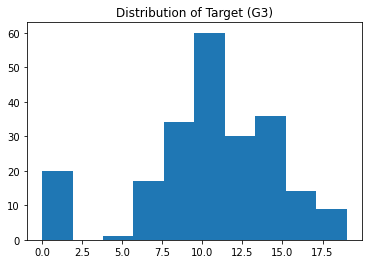

In [49]:
# how do we determine distribution?
plt.hist(y_train)
plt.title('Distribution of Target (G3)')
plt.show()

Cursory conclusion: distribution of the target G3 looks roughly normal, 
 - We will test against generalized linear models to see if we find a better fit

## Modeling

### Baseline

About the initial baseline: 

> Before we begin making models, we need to know how well we can estimate (predict) the final grade (G3) without using any features. This is often done by predicting every observation's target value to be the mean or the median. E.g. we could predict every student's final grade to be the mean final grade of all the students in our training sample. We will try both the mean and the median, see which performs best, and set that evaluation metric value as our baseline performance to beat. 


1. Predict all final grades to be 10.52, which is equal to the mean of G3 for the training sample. Store in `y_train['G3_pred_mean']`. 

2. Predict all final grades to be 11, which is equal to the median of G3 for the training sample. Store in `y_train['G3_pred_median']`.  

3. Compute the RMSE comparing actual final grade (G3) to G3_pred_mean. 

4. Compute the RMSE comparing actual final grade (G3) to G3_pred_median. 

In [50]:
y_train.mean()

10.524886877828054

In [51]:
type(y_train)

pandas.core.series.Series

In [52]:
# We can change y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [55]:
y_train.G3.mean()

10.524886877828054

In [61]:
# 1. Predict G3_pred_mean
G3_pred_mean = y_train.G3.mean()
y_train['G3_pred_mean'] = G3_pred_mean
y_validate['G3_pred_mean'] = G3_pred_mean

# 2. compute G3_pred_median
G3_pred_median = y_train.G3.median()
y_train['G3_pred_median'] = G3_pred_median
y_validate['G3_pred_median'] = G3_pred_median

In [57]:
y_train

,G3,G3_pred_mean,G3_pred_median
142,11,10.524887,11.0
326,16,10.524887,11.0
88,10,10.524887,11.0
118,8,10.524887,11.0
312,11,10.524887,11.0
...,...,...,...
229,12,10.524887,11.0
61,11,10.524887,11.0
38,11,10.524887,11.0
243,12,10.524887,11.0


In [59]:
# 3. RMSE of G3_pred_mean
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_mean) ** 0.5
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_mean) ** 0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  4.5 
Validate/Out-of-Sample:  4.58


In [62]:
# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  4.52 
Validate/Out-of-Sample:  4.69


In [64]:
from sklearn.metrics import explained_variance_score

In [65]:
y_train.head()

,G3,G3_pred_mean,G3_pred_median
142,11,10.524887,11.0
326,16,10.524887,11.0
88,10,10.524887,11.0
118,8,10.524887,11.0
312,11,10.524887,11.0


In [66]:
metric_df = pd.DataFrame(
data=[{
    'model': 'mean_baseline',
    'rmse_validate': rmse_validate, 
    'r^2_validate':explained_variance_score(y_validate.G3,
                                           y_validate.G3_pred_mean)
}])

In [67]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,4.692659,2.220446e-16


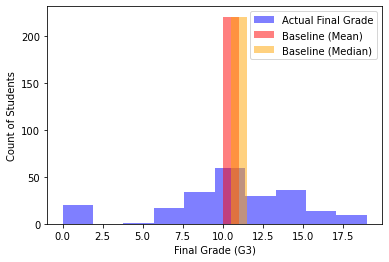

In [70]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.G3, color='blue', alpha=0.5, label='Actual Final Grade')
plt.hist(y_train.G3_pred_mean, bins=1, color='red', alpha=0.5, label='Baseline (Mean)')
plt.hist(y_train.G3_pred_median, bins=1, color='orange', alpha=0.5, label='Baseline (Median)')
plt.xlabel('Final Grade (G3)')
plt.ylabel('Count of Students')
plt.legend()
plt.show()

### LinearRegression (OLS)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for students in training sample using our model (lm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [ ]:
y_train.head()

In [71]:
# create the model object
# 
# make the thing
# 

lm = LinearRegression()

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit the thing
# 
lm.fit(X_train, y_train.G3)

# predict train
# 
# use the thing!
# 
y_train['G3_pred_lm'] = lm.predict(X_train)
y_validate['G3_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
# predict validate
rmse_train = mean_squared_error(y_train.G3,
                               y_train.G3_pred_lm) ** 0.5
rmse_validate = mean_squared_error(y_validate.G3,
                               y_validate.G3_pred_lm) ** 0.5
# evaluate: rmse

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  1.7503546500121143 
Validation/Out-of-Sample:  2.1264081323553436


In [72]:
######## 
# ~~~~~~~~~addendum~~~~~~~
#  we will incrementally build 
# a dataframe for comparison of 
# our metrics for model selection
######


In [76]:
metric_df = metric_df.append(
{
    'model': 'OLS lm 1',
    'rmse_validate': rmse_validate, 
    'r^2_validate':explained_variance_score(y_validate.G3,
                                           y_validate.G3_pred_lm)
}, ignore_index=True)

In [77]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,4.692659,2.220446e-16
1,OLS lm 1,2.126408,7.768072e-01


### LassoLars

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for students in training sample using our model (lars). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [84]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!

lars.fit(X_train, y_train.G3)

# predict train
y_train['G3_pred_lars'] = lars.predict(X_train)
y_validate['G3_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
# predict validate
# evaluate: rmse

rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lars) ** 0.5
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lars) ** 0.5


print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  4.498925523895268 
Validation/Out-of-Sample:  4.578916932633144


In [82]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,4.692659,2.220446e-16
1,OLS lm 1,2.126408,7.768072e-01


In [85]:
metric_df = metric_df.append(
{
    'model': 'LassoLars alpha 1',
    'rmse_validate': rmse_validate, 
    'r^2_validate':explained_variance_score(y_validate.G3,
                                           y_validate.G3_pred_lars)
}, ignore_index=True)

In [86]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,4.692659,2.220446e-16
1,OLS lm 1,2.126408,7.768072e-01
2,LassoLars alpha 1,4.578917,2.220446e-16


### TweedieRegressor (GLM)

1. Fit the model using X_train_scaled and the labels from y_train. 

2. Predict final grade for students in training sample using our model (glm). 

3. Evaluate using RMSE

4. Repeat predictions and evaluation for validation. 

5. Compare RMSE train vs. validation. Overfitting? 

In [88]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!

glm.fit(X_train, y_train.G3)

# predict train
y_train['G3_pred_glm'] = glm.predict(X_train)
y_validate['G3_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
# predict validate
# evaluate: rmse

rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_glm) ** 0.5
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_glm) ** 0.5


print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  2.1831609449720495 
Validation/Out-of-Sample:  2.383365720197387


In [89]:
metric_df = metric_df.append(
    {
    'model': 'GLM Model power 1',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.G3, y_validate.G3_pred_glm)}, ignore_index=True)

In [90]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,4.692659,2.220446e-16
1,OLS lm 1,2.126408,7.768072e-01
2,LassoLars alpha 1,4.578917,2.220446e-16
3,GLM Model power 1,2.383366,7.198167e-01


### Polynomial Regression

Using sklearn.preprocessing.PolynommialFeatures() + sklearn.linear_model.LinearRegression()

1. Create the new features, based on value indicated for degree for train, validate & test. 

2. Fit the Linear Regression model

3. Predict using the transformed (squared or cubed, e.g.) features 

4. Evaluate using RMSE

5. Repeat predictions and evaluation for validation.

6. Compare RMSE train vs. validation. Overfitting?

## **PolynomialFeatures**

In [91]:
# make the polynomial features to get a new set of features

pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [95]:
# X_train_degree2[:,5]

## **LinearRegression**

In [96]:
# create the model object
# make the thing

lm2 = LinearRegression(normalize=True)

# 
# fit the thing

lm2.fit(X_train_degree2, y_train.G3)

LinearRegression(normalize=True)

In [97]:
# predict train
# 
# use the thing!
# 

# evaluate: rmse
# predict validate
y_train['G3_pred_lm2'] = lm2.predict(X_train_degree2)
y_validate['G3_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.G3, y_train.G3_pred_lm2) ** 0.5
rmse_validate = mean_squared_error(y_validate.G3, y_validate.G3_pred_lm2) ** 0.5

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  1.044044782096148 
Validation/Out-of-Sample:  3.422342154558996


In [98]:
metric_df = metric_df.append(
    {
    'model': 'Quadratic Model',
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.G3, y_validate.G3_pred_lm2)}, ignore_index=True)

In [99]:
metric_df

,model,rmse_validate,r^2_validate
0,mean_baseline,4.692659,2.220446e-16
1,OLS lm 1,2.126408,7.768072e-01
2,LassoLars alpha 1,4.578917,2.220446e-16
3,GLM Model power 1,2.383366,7.198167e-01
4,Quadratic Model,3.422342,4.295427e-01


In [100]:
# takeaways:
# OLS seems to be doing the best for us -- 
# Regularization pentalties did not effectively take 
# away training efficacy for the sake of validation efficacy (generalization)
# Polynomial regression seemed to overfit even with n=1 degrees,
# GLM did OK, but not better than OLS, and we have no indication that this is
# a poisson distribution

### Evaluate

**Plotting Actual vs. Predicted Values**

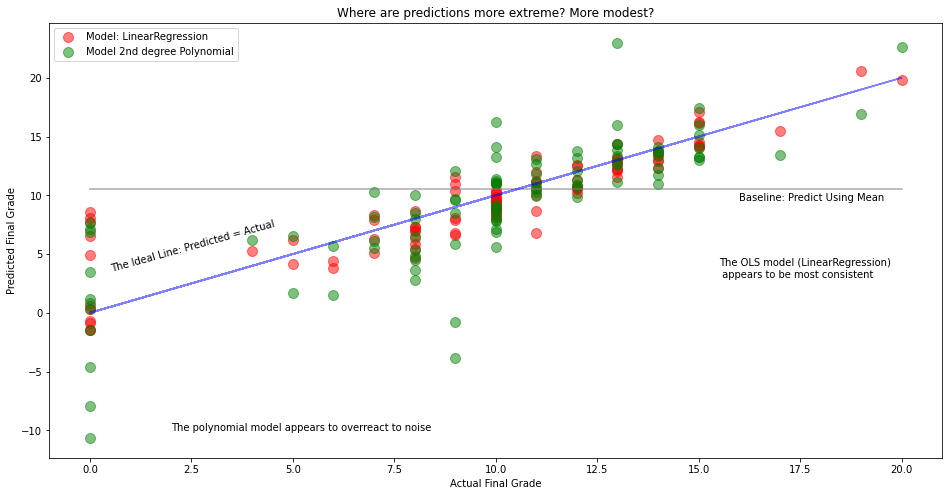

In [101]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.G3, y_validate.G3_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.G3, y_validate.G3, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.G3, y_validate.G3_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
# plt.scatter(y_validate.G3, y_validate.G3_pred_glm, 
#             alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.G3, y_validate.G3_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

**Residual Plots: Plotting the Errors in Predictions**

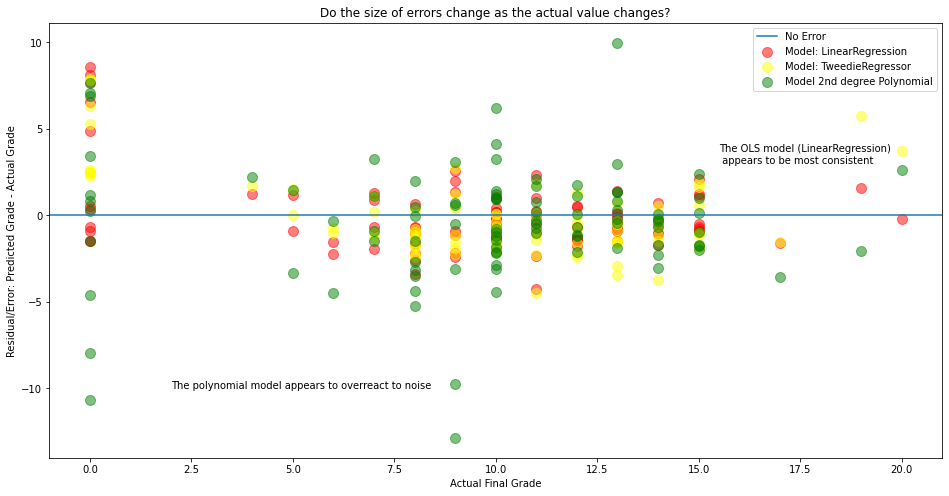

In [102]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.G3, y_validate.G3_pred_lm - y_validate.G3, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.G3, y_validate.G3_pred_glm - y_validate.G3, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.G3, y_validate.G3_pred_lm2 - y_validate.G3, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Residual/Error: Predicted Grade - Actual Grade")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

**Histograms**

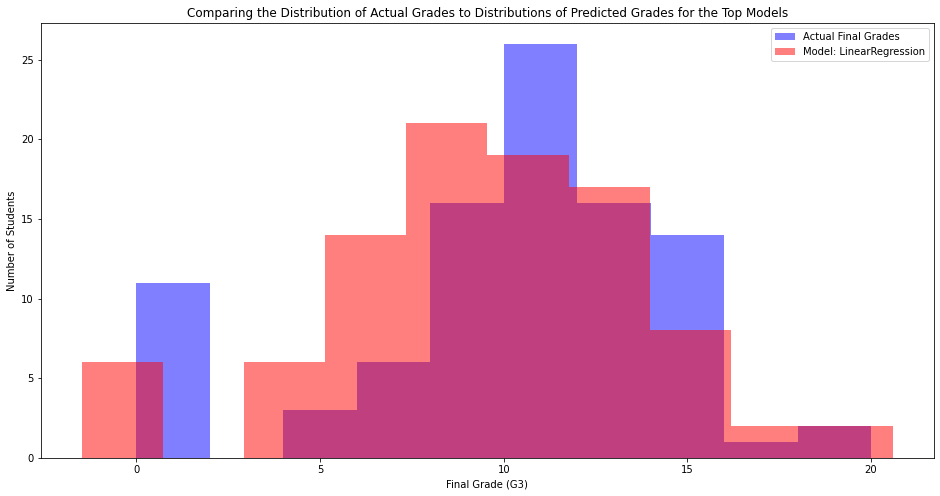

In [103]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.G3, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_validate.G3_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
# plt.hist(y_validate.G3_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
# plt.hist(y_validate.G3_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Final Grade (G3)")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual Grades to Distributions of Predicted Grades for the Top Models")
plt.legend()
plt.show()

In [104]:
# final steps before putting into production:
# select best model:
# assess on test set

In [105]:
# OLS was my best model, so I will utilize this to evaluate results on my test set

In [107]:
# capture predictions on test
y_pred_test = lm.predict(X_test)

In [108]:
# get error metrics:
rmse_test = mean_squared_error(y_test, y_pred_test) ** 0.5

In [109]:
rmse_test

1.9229879901741005